In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
'''
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
matplotlib.rc('figure', figsize=(16, 8))
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
'''

"\nSMALL_SIZE = 8\nMEDIUM_SIZE = 16\nBIGGER_SIZE = 20\nmatplotlib.rc('figure', figsize=(16, 8))\nplt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels\nplt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the x and y labels\nplt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels\nplt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels\n"

In [3]:
file_names = [
    'CL=F.csv',
    'UUP.csv',
    'US_GDP_Monthly.csv',
    'us-crude-oil-production-historical-chart.csv',
    'tweet_sentiment_df.csv']

In [4]:
file_path = "../Data/"

In [5]:
cols = ['date', 'close', 'vader compound', 
        'usalorsgpnostsam',
        'world petroleum consumption', 
        'u.s. petroleum consumption',
        'value']

In [6]:
data = pd.DataFrame()

In [7]:
dfs = []
for i in range(len(file_names)):
    file_name = file_path + file_names[i]
    #print(file_name)
    df = pd.read_csv(file_name,
                    parse_dates = True,
                    infer_datetime_format = True)

    df.columns = df.columns.str.lower()

    n = []
    for c in cols:
        if df.columns.str.contains(c).any():
            n.append(df.columns.get_loc(c))
    df = df.iloc[:,n]
    df = df.replace('NaN', np.nan)
    df.dropna()

    #df.dropna()
    try:
        df['date'] = pd.to_datetime(df['date'], infer_datetime_format = True)
    except:
        print(df)
    df = df.set_index('date')

    df.sort_index(inplace = True)
    dfs.append(df)
#    if i == 0:
#        data = df.copy()
#    else:
#        data.join(df, how='outer', rsuffix=str(i))

In [8]:
data = pd.concat(dfs[:-1], join='outer', axis=1)

In [9]:
daily_average = dfs[4].resample('D').mean()

In [10]:
data = data.join(daily_average, how='outer')

## Set plot style

In [11]:
plt.style.use('seaborn-poster')

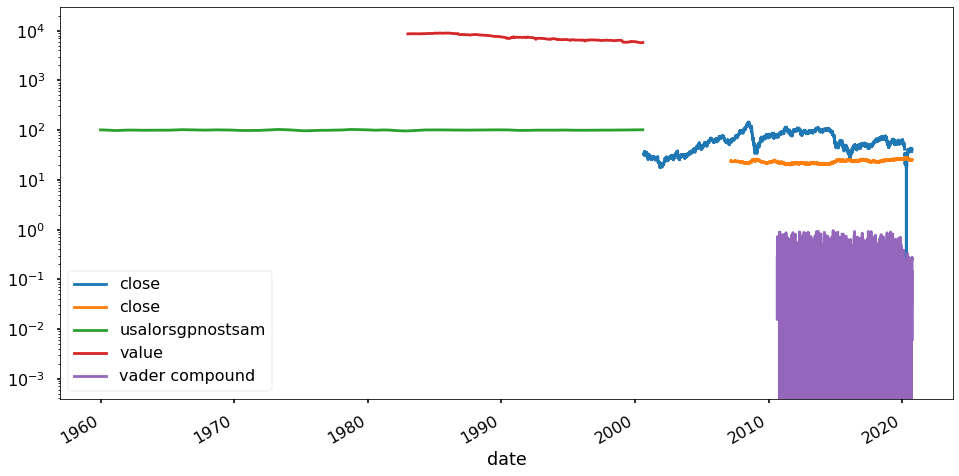

In [12]:
data.plot(logy=True, figsize=(16,8))

In [13]:
df_all = data.interpolate(method ='linear')

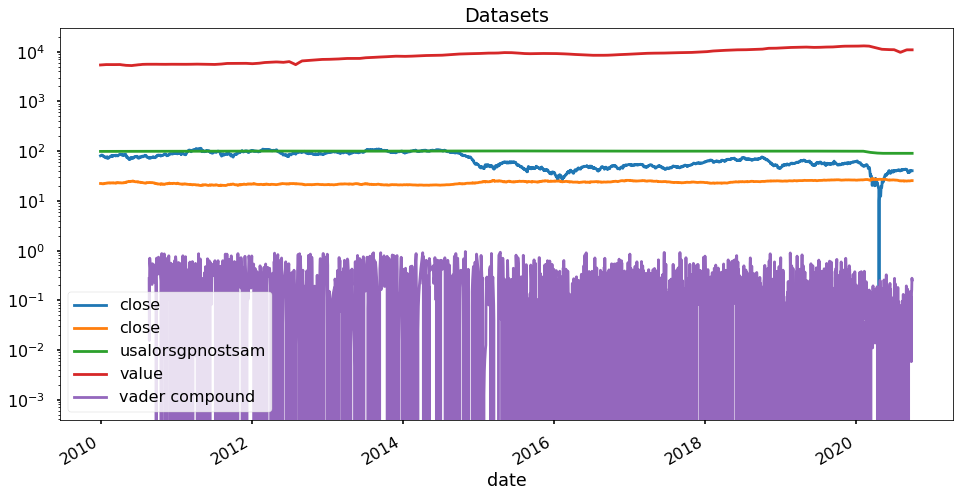

In [14]:
df_all['2010':'2020'].plot(logy=True, figsize=(16,8), title='Datasets')
plt.savefig('datasets.png')

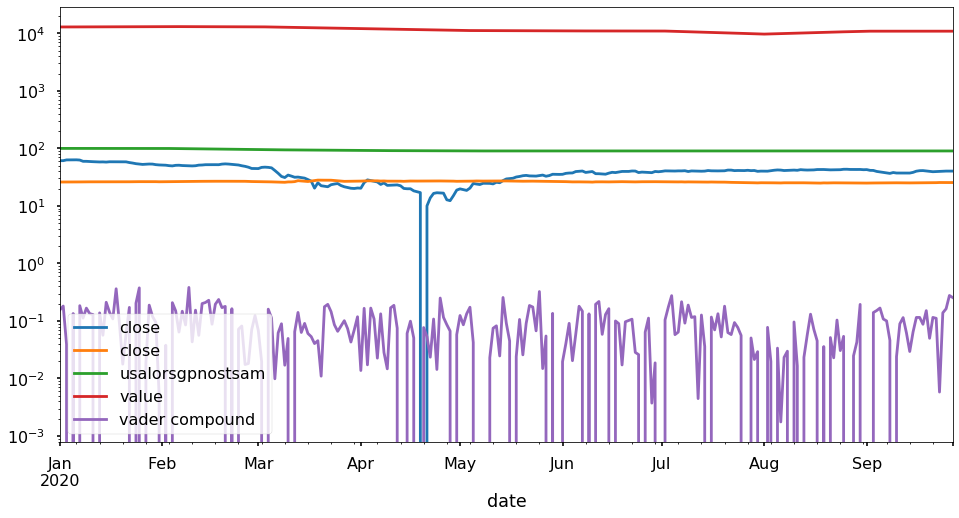

In [15]:
df_all['2020'].plot(logy=True, figsize=(16,8))

In [16]:
df_all.columns

Index(['close', 'close', 'usalorsgpnostsam', 'value', 'vader compound'], dtype='object')

In [17]:
df_all.columns = ['price', 'uup', 'gdp', 'prod', 'vader' ]

In [18]:
df_2 = df_all['2019':'2020']

In [19]:
df_2

price        uup         gdp          prod     vader
date                                                                
2019-01-01  45.975000  25.045000  100.075204  11900.000000  0.717625
2019-01-02  46.540000  25.140000  100.074436  11906.451613 -0.285450
2019-01-03  47.090000  25.000000  100.073667  11912.903226 -0.215950
2019-01-04  47.960000  24.960000  100.072898  11919.354839 -0.035650
2019-01-05  48.146667  24.923333  100.072129  11925.806452 -0.425675
...               ...        ...         ...           ...       ...
2020-09-23  39.930000  25.520000   90.264283  10900.000000  0.005812
2020-09-24  40.310000  25.480000   90.264283  10900.000000  0.138539
2020-09-25  40.310000  25.480000   90.264283  10900.000000  0.163099
2020-09-26  40.310000  25.480000   90.264283  10900.000000  0.277375
2020-09-27  40.310000  25.480000   90.264283  10900.000000  0.255410

[636 rows x 5 columns]

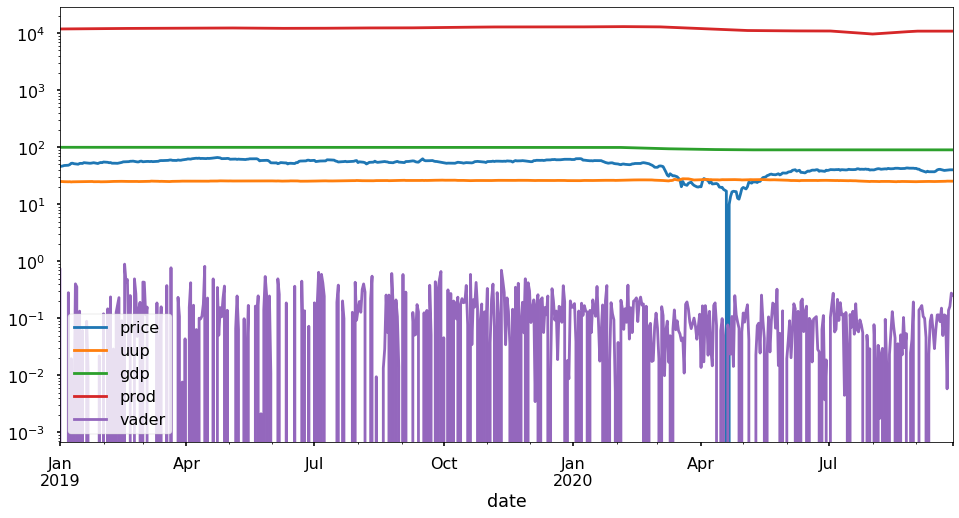

In [20]:
df_2.plot(logy=True, figsize=(16,8))

In [21]:
corr_matrix = df_2.corr(method = "spearman").abs()

In [22]:
import seaborn as sns

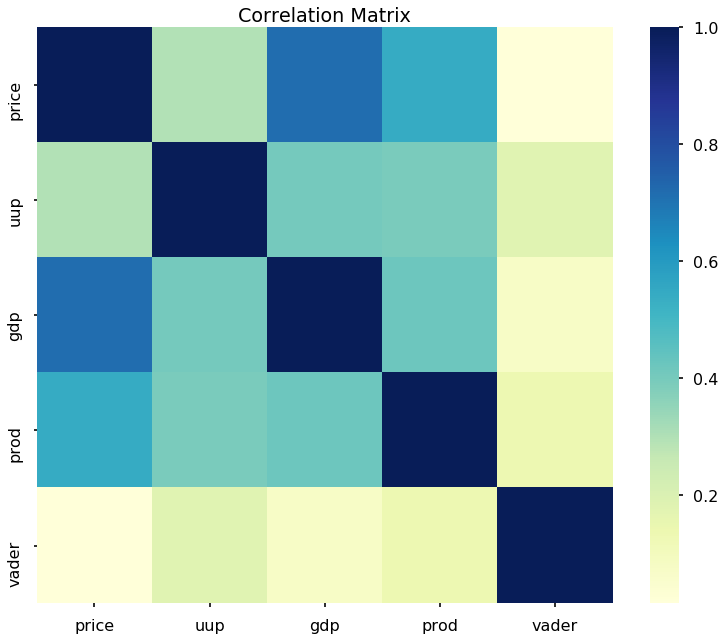

In [23]:
# Draw the heatmap
#sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", 
            square=True, ax = ax)
ax.set_title('Correlation Matrix')
f.tight_layout()
plt.savefig("correlation_matrix.png")

# Part I: Build and Train the LSTM RNN

In [24]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [25]:
# 252 days (1 year) for testing 
split = 252

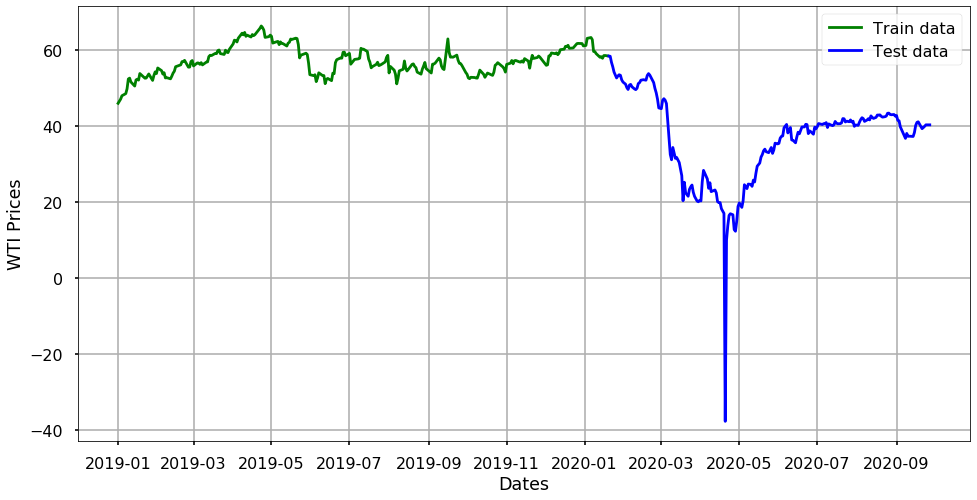

In [26]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('WTI Prices')
plt.plot(df_2.iloc[:-split, 0], 'green', label='Train data')
plt.plot(df_2.iloc[-split:, 0], 'blue', label='Test data')
plt.legend()

In [27]:
# Predict Closing Prices using a 30 day window of previous closing prices
window_size = 73

# Column index 0 is the `price` column 
target_column = 0

feature_column = 0
X, y = window_data(df_2, window_size, feature_column, target_column)

In [46]:
# split 252 days (1 year) for testing 
X_train = X[:-split]
y_train = y[:-split]

X_test = X[-split:]
y_test = y[-split:]

In [47]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.

scaler = MinMaxScaler()
scaler.fit(X)
# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)
# Reshape the features for the model
# YOUR CODE HERE!
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [48]:
# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.80443568]
  [0.80987203]
  [0.81516405]
  [0.82353507]
  [0.82533115]
  [0.82712723]
  [0.82892331]
  [0.84104686]
  [0.86587126]
  [0.86808429]
  [0.85846243]
  [0.85499856]
  [0.85153469]
  [0.84807082]
  [0.86346579]
  [0.86539017]
  [0.86308092]
  [0.87972674]
  [0.87676802]
  [0.87380929]
  [0.87085057]
  [0.86789185]
  [0.86837294]
  [0.87328009]
  [0.87866833]
  [0.87321595]
  [0.86776356]
  [0.86231117]
  [0.87501203]
  [0.88386414]
  [0.87963052]
  [0.89377466]
  [0.89152956]
  [0.88928445]
  [0.88703935]
  [0.87837968]
  [0.88174733]
  [0.86856538]
  [0.86933513]
  [0.86834087]
  [0.86734661]
  [0.86635235]
  [0.87299144]
  [0.88068893]
  [0.88559607]
  [0.89694987]
  [0.8981526 ]
  [0.89935534]
  [0.90055807]
  [0.9017608 ]
  [0.90974695]
  [0.91013182]
  [0.91301838]
  [0.90730941]
  [0.90160044]
  [0.89589147]
  [0.8960839 ]
  [0.90993938]
  [0.9126335 ]
  [0.89897046]
  [0.90150422]
  [0.90403797]
  [0.90657173]
  [0.90628308]
  [0.90301164]
  

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [50]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# YOUR CODE HERE!
model = Sequential()

# Initial model setup
number_units = 55  
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

# Train the model
epochs = 35
batch_size=30
training_history = model.fit(X_train, y_train, 
          epochs=epochs, shuffle=False,
          validation_data=(X_test, y_test),
          batch_size=batch_size, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 73, 55)            12540     
_________________________________________________________________
dropout_6 (Dropout)          (None, 73, 55)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 73, 55)            24420     
_________________________________________________________________
dropout_7 (Dropout)          (None, 73, 55)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 55)                24420     
_________________________________________________________________
dropout_8 (Dropout)          (None, 55)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [51]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.015245656039388407

In [52]:
# Make some predictions
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [53]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [55]:
# Create a DataFrame of Real and Predicted values
df_prices = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df_2.index[-len(real_prices)-1:-1]) 
df_prices['price'] = df_2['price']
df_prices

Real  Predicted  price
date                               
2020-01-19  58.44  58.852348  58.44
2020-01-20  58.39  58.744961  58.39
2020-01-21  58.34  58.649117  58.34
2020-01-22  56.74  58.564667  56.74
2020-01-23  55.59  58.482338  55.59
...           ...        ...    ...
2020-09-22  39.60  48.603199  39.60
2020-09-23  39.93  48.657848  39.93
2020-09-24  40.31  48.713974  40.31
2020-09-25  40.31  48.771656  40.31
2020-09-26  40.31  48.830215  40.31

[252 rows x 3 columns]

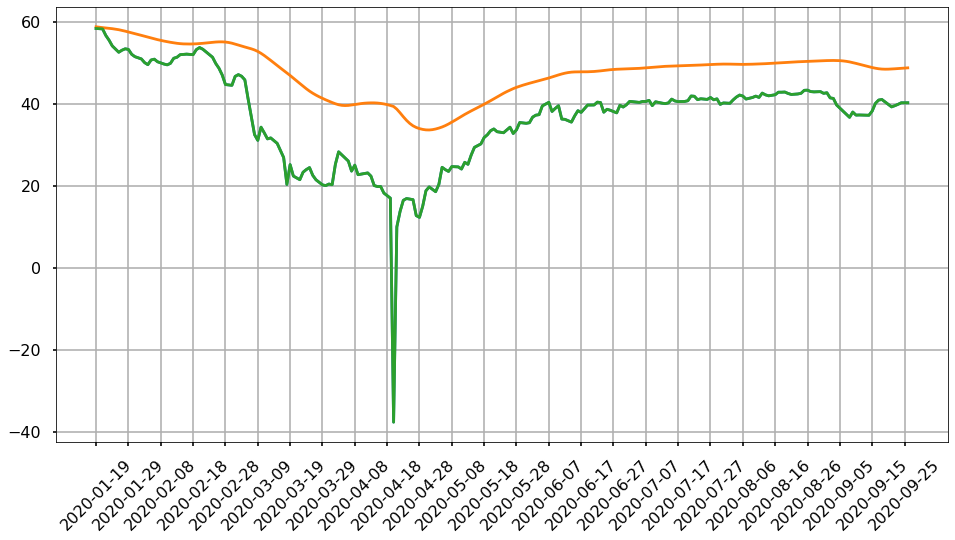

In [56]:
plt.figure(figsize=(16,8))
plt.plot(df_prices)
plt.xticks(df_prices.index[::10],rotation=45)
#plt.legend()
plt.grid(True)
plt.show()

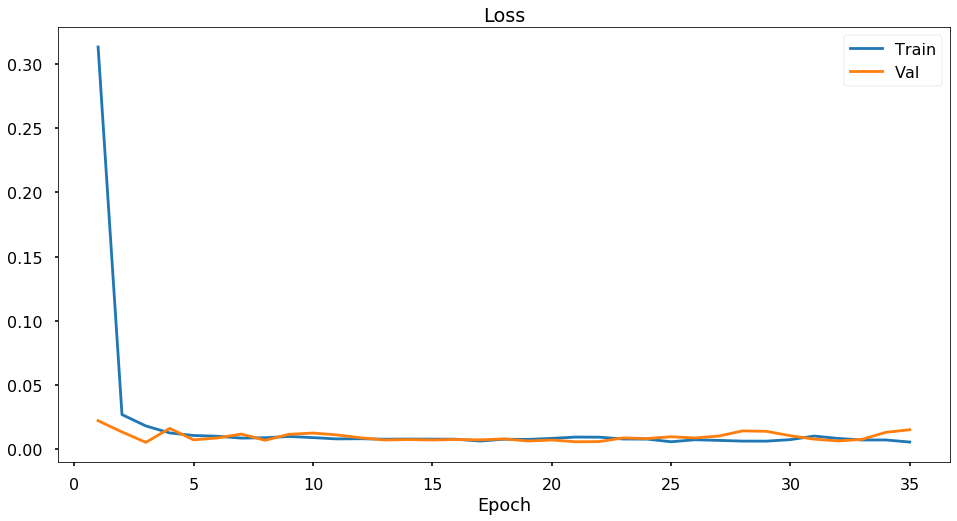

In [57]:
# Plotting loss
loss_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": training_history.history["loss"],
        "Val": training_history.history["val_loss"],
    }
)
loss_df.set_index("Epoch", inplace=True)
loss_df.plot(title="Loss", figsize=(16,8))

In [58]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


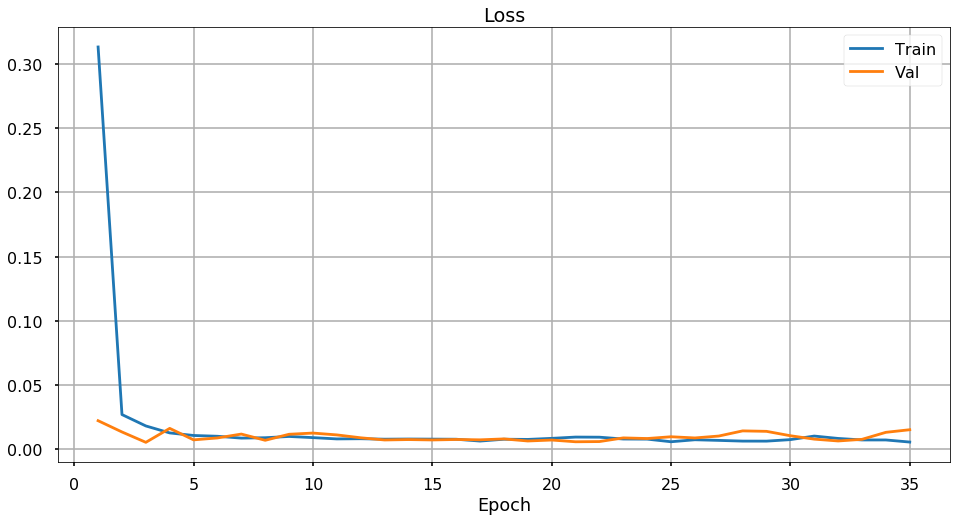

In [59]:
plt.style.use('seaborn-poster')
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Epoch')
plt.title('Loss')
plt.plot(loss_df['Train'],label='Train')
plt.plot(loss_df['Val'], label='Val')
plt.legend()
plt.savefig("rnn_loss.png")

In [61]:
oil_df = df_prices.copy()
oil_df['Real u/d'] = np.nan
oil_df['Predicted u/d'] = np.nan
# Initialize variable to hold previous price
real_pre_price = 0
pred_pre_price = 0
for index, row in oil_df.iterrows():

    if real_pre_price == 0:
        oil_df.loc[index, "Real u/d"] = 0
    elif row["Real"] < real_pre_price:
        oil_df.loc[index, "Real u/d"] = -1
    elif row["Real"] > real_pre_price:
        oil_df.loc[index, "Real u/d"] = 1
    else:
        oil_df.loc[index, "Real u/d"] = 0

    real_pre_price = row["Real"]

    if pred_pre_price == 0:
        oil_df.loc[index, "Predicted u/d"] = 0
    elif row["Predicted"] < pred_pre_price:
        oil_df.loc[index, "Predicted u/d"] = -1
    elif row["Predicted"] > pred_pre_price:
        oil_df.loc[index, "Predicted u/d"] = 1
    else:
        oil_df.loc[index, "Predicted u/d"] = 0

    pred_pre_price = row["Predicted"]

    
# Print the DataFrame
oil_df

Real  Predicted  price  Real u/d  Predicted u/d
date                                                        
2020-01-19  58.44  58.852348  58.44       0.0            0.0
2020-01-20  58.39  58.744961  58.39      -1.0           -1.0
2020-01-21  58.34  58.649117  58.34      -1.0           -1.0
2020-01-22  56.74  58.564667  56.74      -1.0           -1.0
2020-01-23  55.59  58.482338  55.59      -1.0           -1.0
...           ...        ...    ...       ...            ...
2020-09-22  39.60  48.603199  39.60       1.0            1.0
2020-09-23  39.93  48.657848  39.93       1.0            1.0
2020-09-24  40.31  48.713974  40.31       1.0            1.0
2020-09-25  40.31  48.771656  40.31       0.0            1.0
2020-09-26  40.31  48.830215  40.31       0.0            1.0

[252 rows x 5 columns]

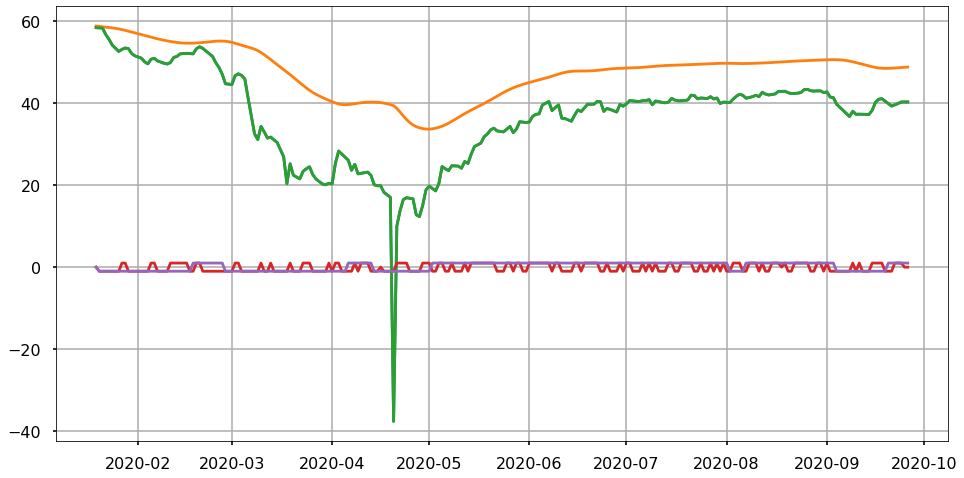

In [62]:
plt.figure(figsize=(16,8))
plt.plot(oil_df)
#plt.xticks(oil_df.index[::10],rotation=45)
#plt.legend()
plt.grid(True)
plt.show()

In [63]:
df_2

price        uup         gdp          prod     vader
date                                                                
2019-01-01  45.975000  25.045000  100.075204  11900.000000  0.717625
2019-01-02  46.540000  25.140000  100.074436  11906.451613 -0.285450
2019-01-03  47.090000  25.000000  100.073667  11912.903226 -0.215950
2019-01-04  47.960000  24.960000  100.072898  11919.354839 -0.035650
2019-01-05  48.146667  24.923333  100.072129  11925.806452 -0.425675
...               ...        ...         ...           ...       ...
2020-09-23  39.930000  25.520000   90.264283  10900.000000  0.005812
2020-09-24  40.310000  25.480000   90.264283  10900.000000  0.138539
2020-09-25  40.310000  25.480000   90.264283  10900.000000  0.163099
2020-09-26  40.310000  25.480000   90.264283  10900.000000  0.277375
2020-09-27  40.310000  25.480000   90.264283  10900.000000  0.255410

[636 rows x 5 columns]

In [67]:
# real crude prices
df_p = df_2.iloc[-len(real_prices)-1:-1,0].to_frame()
df_p['real'] = df_prices['price']
df_p

price   real
date                    
2020-01-19  58.44  58.44
2020-01-20  58.39  58.39
2020-01-21  58.34  58.34
2020-01-22  56.74  56.74
2020-01-23  55.59  55.59
...           ...    ...
2020-09-22  39.60  39.60
2020-09-23  39.93  39.93
2020-09-24  40.31  40.31
2020-09-25  40.31  40.31
2020-09-26  40.31  40.31

[252 rows x 2 columns]

In [68]:
#window_size = 30
target_column = 0 # Column index 0 is the `price` column 
# Use latest 73 days (3 months) for testing
#split = 73

for f_col in df_2.columns:
    #f_col = "uup"
    # Predict Closing Prices using a 30 day window of previous closing prices

    feature_column = df_2.columns.get_loc(f_col)

    X, y = window_data(df_2, window_size, feature_column, target_column)

    X_train = X[:-split]
    X_test = X[-split:]

    y_train = y[:-split]
    y_test = y[-split:]

    scaler.fit(X)
    # Scale the features training and testing sets
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    # Fit the MinMaxScaler object with the target data Y
    scaler.fit(y)

    # Scale the target training and testing sets
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    # Reshape the features for the model
    # YOUR CODE HERE!
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Train the model
    # epochs = 35
    # batch_size=30
    training_history = model.fit(X_train, y_train, 
              epochs=epochs, shuffle=False,
              validation_data=(X_test, y_test),
              batch_size=batch_size, verbose=0)
    #model.fit(X_train, y_train, epochs = 35, batch_size = 30)

    # Evaluate the model
    model.evaluate(X_test, y_test, verbose=0)

    # Make some predictions
    predicted = model.predict(X_test)

    # Recover the original prices instead of the scaled version
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Create a DataFrame of Real and Predicted values
    p_col = f_col + "_p"

    df_p[p_col] = predicted_prices.ravel()

    u_col = f_col + "_u"
    df_p[u_col] = np.nan
    # Initialize variable to hold previous price
    previous_price = 0
    for index, row in df_p.iterrows():

        if previous_price == 0:
            df_p.loc[index, u_col] = 0
        elif row[p_col] < previous_price:
            df_p.loc[index, u_col] = -1
        elif row[p_col] > previous_price:
            df_p.loc[index, u_col] = 1
        else:
            df_p.loc[index, u_col] = 0

        previous_price = row[p_col]

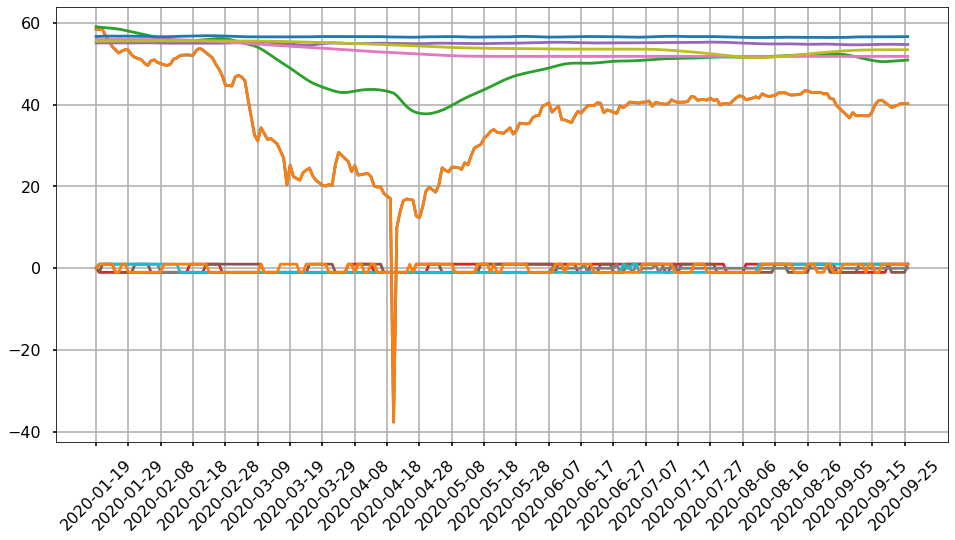

In [69]:
plt.figure(figsize=(16,8))
plt.plot(df_p)
plt.xticks(df_p.index[::10],rotation=45)
#plt.legend()
plt.grid(True)
plt.show()

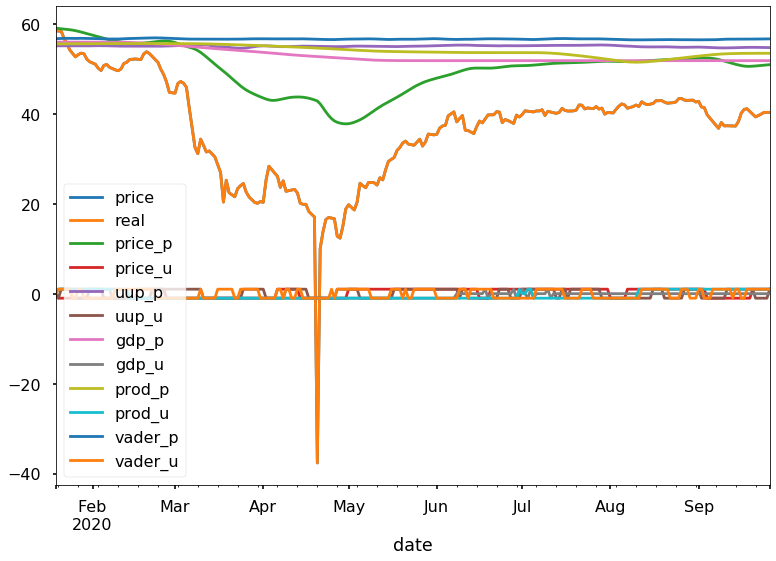

In [70]:
ax = df_p.plot()
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='lower left')  

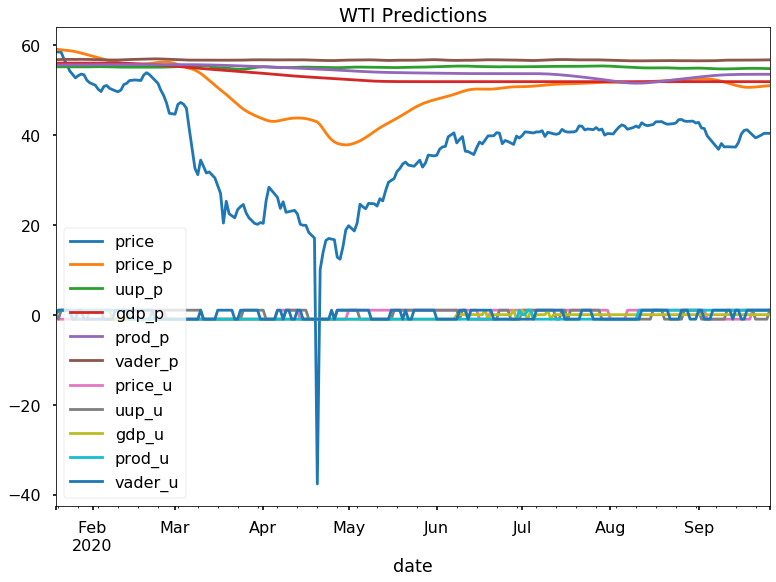

In [71]:
col_list = ['price',
    'price_p', 'uup_p', 'gdp_p', 'prod_p', 'vader_p',
    'price_u', 'uup_u', 'gdp_u', 'prod_u', 'vader_u']
df_p[col_list].plot(kind='line')
plt.title('WTI Predictions')
plt.legend(loc='lower left')
plt.savefig("rnn_output.png")
plt.show()


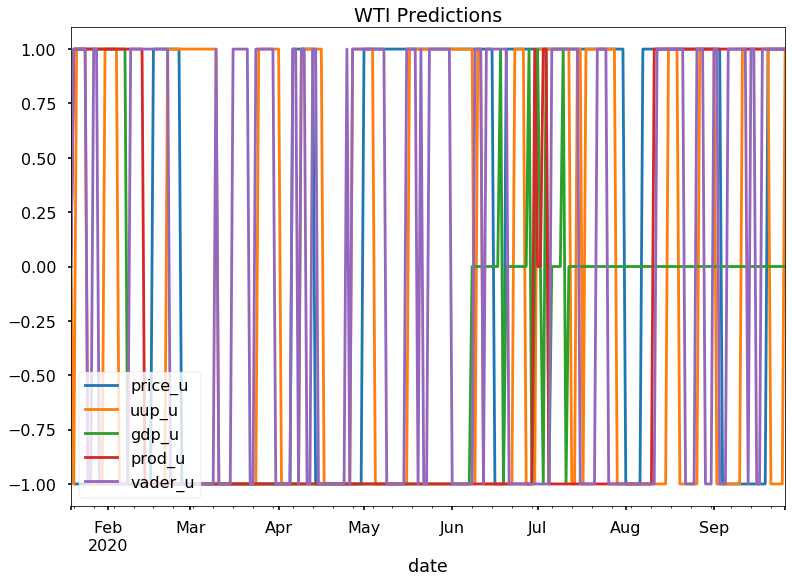

In [72]:
col_list = ['price_u', 'uup_u', 'gdp_u', 'prod_u', 'vader_u']
df_p[col_list].plot(kind='line')
plt.title('WTI Predictions')
plt.legend(loc='lower left')
plt.savefig("rnn_output_trend.png")
plt.show()



# Part II: Random Forest

In [73]:
df_p

price   real    price_p  price_u      uup_p  uup_u      gdp_p  \
date                                                                        
2020-01-19  58.44  58.44  59.045261      0.0  55.102703    0.0  55.927391   
2020-01-20  58.39  58.39  58.957199     -1.0  55.100842   -1.0  55.927490   
2020-01-21  58.34  58.34  58.880894     -1.0  55.101387    1.0  55.927601   
2020-01-22  56.74  56.74  58.815624     -1.0  55.104176    1.0  55.927711   
2020-01-23  55.59  55.59  58.752453     -1.0  55.109913    1.0  55.927826   
...           ...    ...        ...      ...        ...    ...        ...   
2020-09-22  39.60  39.60  50.681896      1.0  54.750629   -1.0  51.801105   
2020-09-23  39.93  39.93  50.742790      1.0  54.735344   -1.0  51.801105   
2020-09-24  40.31  40.31  50.801182      1.0  54.714443   -1.0  51.801105   
2020-09-25  40.31  40.31  50.857925      1.0  54.705299   -1.0  51.801105   
2020-09-26  40.31  40.31  50.913132      1.0  54.707775    1.0  51.801105   

            gdp_u     prod_p  prod_u    vader_p  vader_u  
date                                                      
2020-01-19    0.0  55.526760     0.0  56.680740      0.0  
2020-01-20    1.0  55.530762     1.0  56.710991      1.0  
2020-01-21    1.0  55.534824     1.0  56.743481      1.0  
2020-01-22    1.0  55.538921     1.0  56.762375      1.0  
2020-01-23    1.0  55.543041     1.0  56.764797      1.0  
...           ...        ...     ...        ...      ...  
2020-09-22    0.0  53.439861     1.0  56.615810      1.0  
2020-09-23    0.0  53.440907     1.0  56.626602      1.0  
2020-09-24    0.0  53.441620     1.0  56.640545      1.0  
2020-09-25    0.0  53.442097     1.0  56.642750      1.0  
2020-09-26    0.0  53.442394     1.0  56.644131      1.0  

[252 rows x 12 columns]

In [74]:
df_p['daily_return'] = df_p['price'].pct_change()
df_p

price   real    price_p  price_u      uup_p  uup_u      gdp_p  \
date                                                                        
2020-01-19  58.44  58.44  59.045261      0.0  55.102703    0.0  55.927391   
2020-01-20  58.39  58.39  58.957199     -1.0  55.100842   -1.0  55.927490   
2020-01-21  58.34  58.34  58.880894     -1.0  55.101387    1.0  55.927601   
2020-01-22  56.74  56.74  58.815624     -1.0  55.104176    1.0  55.927711   
2020-01-23  55.59  55.59  58.752453     -1.0  55.109913    1.0  55.927826   
...           ...    ...        ...      ...        ...    ...        ...   
2020-09-22  39.60  39.60  50.681896      1.0  54.750629   -1.0  51.801105   
2020-09-23  39.93  39.93  50.742790      1.0  54.735344   -1.0  51.801105   
2020-09-24  40.31  40.31  50.801182      1.0  54.714443   -1.0  51.801105   
2020-09-25  40.31  40.31  50.857925      1.0  54.705299   -1.0  51.801105   
2020-09-26  40.31  40.31  50.913132      1.0  54.707775    1.0  51.801105   

            gdp_u     prod_p  prod_u    vader_p  vader_u  daily_return  
date                                                                    
2020-01-19    0.0  55.526760     0.0  56.680740      0.0           NaN  
2020-01-20    1.0  55.530762     1.0  56.710991      1.0     -0.000856  
2020-01-21    1.0  55.534824     1.0  56.743481      1.0     -0.000856  
2020-01-22    1.0  55.538921     1.0  56.762375      1.0     -0.027425  
2020-01-23    1.0  55.543041     1.0  56.764797      1.0     -0.020268  
...           ...        ...     ...        ...      ...           ...  
2020-09-22    0.0  53.439861     1.0  56.615810      1.0      0.007377  
2020-09-23    0.0  53.440907     1.0  56.626602      1.0      0.008333  
2020-09-24    0.0  53.441620     1.0  56.640545      1.0      0.009517  
2020-09-25    0.0  53.442097     1.0  56.642750      1.0      0.000000  
2020-09-26    0.0  53.442394     1.0  56.644131      1.0      0.000000  

[252 rows x 13 columns]

In [75]:
trading_signals_df = df_p

In [76]:
# Set x variable list of features
x_var_list = ['price_u', 'uup_u', 'gdp_u', 'prod_u', 'vader_u']

# Filter by x-variable list
trading_signals_df[x_var_list].tail()

price_u  uup_u  gdp_u  prod_u  vader_u
date                                              
2020-09-22      1.0   -1.0    0.0     1.0      1.0
2020-09-23      1.0   -1.0    0.0     1.0      1.0
2020-09-24      1.0   -1.0    0.0     1.0      1.0
2020-09-25      1.0   -1.0    0.0     1.0      1.0
2020-09-26      1.0    1.0    0.0     1.0      1.0

In [77]:
import hvplot
import hvplot.pandas

In [78]:
#!conda install selenium

In [79]:
trading_signals_table = trading_signals_df[x_var_list].tail(15).hvplot.table()
hvplot.save(trading_signals_table, 'trading_signals_table.png')

In [80]:
trading_signals_table

:Table   [date,price_u,uup_u,gdp_u,prod_u,vader_u]

In [81]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list].tail()

price_u  uup_u  gdp_u  prod_u  vader_u
date                                              
2020-09-22      1.0   -1.0    0.0     1.0      1.0
2020-09-23      1.0   -1.0    0.0     1.0      1.0
2020-09-24      1.0   -1.0    0.0     1.0      1.0
2020-09-25      1.0   -1.0    0.0     1.0      1.0
2020-09-26      1.0   -1.0    0.0     1.0      1.0

In [82]:
# Drop NAs and replace positive/negative infinity values
trading_signals_df.dropna(subset=x_var_list, inplace=True)
trading_signals_df.dropna(subset=['daily_return'], inplace=True)
trading_signals_df = trading_signals_df.replace([np.inf, -np.inf], np.nan)
trading_signals_df.head()

price   real    price_p  price_u      uup_p  uup_u      gdp_p  \
date                                                                        
2020-01-20  58.39  58.39  58.957199      0.0  55.100842    0.0  55.927490   
2020-01-21  58.34  58.34  58.880894     -1.0  55.101387   -1.0  55.927601   
2020-01-22  56.74  56.74  58.815624     -1.0  55.104176    1.0  55.927711   
2020-01-23  55.59  55.59  58.752453     -1.0  55.109913    1.0  55.927826   
2020-01-24  54.19  54.19  58.680542     -1.0  55.110443    1.0  55.927937   

            gdp_u     prod_p  prod_u    vader_p  vader_u  daily_return  
date                                                                    
2020-01-20    0.0  55.530762     0.0  56.710991      0.0     -0.000856  
2020-01-21    1.0  55.534824     1.0  56.743481      1.0     -0.000856  
2020-01-22    1.0  55.538921     1.0  56.762375      1.0     -0.027425  
2020-01-23    1.0  55.543041     1.0  56.764797      1.0     -0.020268  
2020-01-24    1.0  55.547176     1.0  56.770454      1.0     -0.025184

In [83]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
trading_signals_df['Positive Return'] = np.where(trading_signals_df['daily_return'] > 0, 1.0, 0.0)
trading_signals_df

price   real    price_p  price_u      uup_p  uup_u      gdp_p  \
date                                                                        
2020-01-20  58.39  58.39  58.957199      0.0  55.100842    0.0  55.927490   
2020-01-21  58.34  58.34  58.880894     -1.0  55.101387   -1.0  55.927601   
2020-01-22  56.74  56.74  58.815624     -1.0  55.104176    1.0  55.927711   
2020-01-23  55.59  55.59  58.752453     -1.0  55.109913    1.0  55.927826   
2020-01-24  54.19  54.19  58.680542     -1.0  55.110443    1.0  55.927937   
...           ...    ...        ...      ...        ...    ...        ...   
2020-09-22  39.60  39.60  50.681896      1.0  54.750629   -1.0  51.801105   
2020-09-23  39.93  39.93  50.742790      1.0  54.735344   -1.0  51.801105   
2020-09-24  40.31  40.31  50.801182      1.0  54.714443   -1.0  51.801105   
2020-09-25  40.31  40.31  50.857925      1.0  54.705299   -1.0  51.801105   
2020-09-26  40.31  40.31  50.913132      1.0  54.707775   -1.0  51.801105   

            gdp_u     prod_p  prod_u    vader_p  vader_u  daily_return  \
date                                                                     
2020-01-20    0.0  55.530762     0.0  56.710991      0.0     -0.000856   
2020-01-21    1.0  55.534824     1.0  56.743481      1.0     -0.000856   
2020-01-22    1.0  55.538921     1.0  56.762375      1.0     -0.027425   
2020-01-23    1.0  55.543041     1.0  56.764797      1.0     -0.020268   
2020-01-24    1.0  55.547176     1.0  56.770454      1.0     -0.025184   
...           ...        ...     ...        ...      ...           ...   
2020-09-22    0.0  53.439861     1.0  56.615810      1.0      0.007377   
2020-09-23    0.0  53.440907     1.0  56.626602      1.0      0.008333   
2020-09-24    0.0  53.441620     1.0  56.640545      1.0      0.009517   
2020-09-25    0.0  53.442097     1.0  56.642750      1.0      0.000000   
2020-09-26    0.0  53.442394     1.0  56.644131      1.0      0.000000   

            Positive Return  
date                         
2020-01-20              0.0  
2020-01-21              0.0  
2020-01-22              0.0  
2020-01-23              0.0  
2020-01-24              0.0  
...                     ...  
2020-09-22              1.0  
2020-09-23              1.0  
2020-09-24              1.0  
2020-09-25              0.0  
2020-09-26              0.0  

[251 rows x 14 columns]

In [84]:
# Construct training start and end dates
training_start = trading_signals_df.index.min().strftime(format= '%Y-%m-%d')
training_end = '2020-08-14'

# Construct testing start and end dates
testing_start =  '2020-08-15'
testing_end = trading_signals_df.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2020-01-20
Training End: 2020-08-14
Testing Start: 2020-08-15
Testing End: 2020-09-26


In [85]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df['Positive Return'][training_start:training_end]

X_train.tail()

price_u  uup_u  gdp_u  prod_u  vader_u
date                                              
2020-08-10      1.0   -1.0    0.0    -1.0     -1.0
2020-08-11      1.0   -1.0    0.0    -1.0     -1.0
2020-08-12      1.0   -1.0    0.0     1.0     -1.0
2020-08-13      1.0   -1.0    0.0     1.0      1.0
2020-08-14      1.0   -1.0    0.0     1.0      1.0

In [86]:
y_train.tail()

date
2020-08-10    1.0
2020-08-11    0.0
2020-08-12    1.0
2020-08-13    0.0
2020-08-14    0.0
Name: Positive Return, dtype: float64

In [87]:
# Construct the X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df['Positive Return'][testing_start:testing_end]

X_test.tail()

price_u  uup_u  gdp_u  prod_u  vader_u
date                                              
2020-09-22      1.0   -1.0    0.0     1.0      1.0
2020-09-23      1.0   -1.0    0.0     1.0      1.0
2020-09-24      1.0   -1.0    0.0     1.0      1.0
2020-09-25      1.0   -1.0    0.0     1.0      1.0
2020-09-26      1.0   -1.0    0.0     1.0      1.0

In [88]:
y_test.tail()

date
2020-09-22    1.0
2020-09-23    1.0
2020-09-24    1.0
2020-09-25    0.0
2020-09-26    0.0
Name: Positive Return, dtype: float64

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [90]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model_rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model_rf.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model_rf.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

Positive Return  Predicted Value
date                                        
2020-08-15              1.0              0.0
2020-08-16              1.0              0.0
2020-08-17              1.0              0.0
2020-08-18              0.0              0.0
2020-08-19              1.0              0.0
2020-08-20              0.0              0.0
2020-08-21              0.0              0.0
2020-08-22              1.0              0.0
2020-08-23              1.0              1.0
2020-08-24              1.0              1.0
2020-08-25              1.0              1.0
2020-08-26              1.0              1.0
2020-08-27              0.0              0.0
2020-08-28              0.0              0.0
2020-08-29              1.0              0.0
2020-08-30              1.0              0.0
2020-08-31              0.0              0.0
2020-09-01              1.0              0.0
2020-09-02              0.0              0.0
2020-09-03              0.0              0.0
2020-09-04              0.0              1.0
2020-09-05              0.0              0.0
2020-09-06              0.0              0.0
2020-09-07              0.0              0.0
2020-09-08              0.0              0.0
2020-09-09              1.0              0.0
2020-09-10              0.0              0.0
2020-09-11              1.0              0.0
2020-09-12              0.0              0.0
2020-09-13              0.0              0.0
2020-09-14              0.0              0.0
2020-09-15              1.0              0.0
2020-09-16              1.0              0.0
2020-09-17              1.0              0.0
2020-09-18              1.0              0.0
2020-09-19              0.0              0.0
2020-09-20              0.0              0.0
2020-09-21              0.0              0.0
2020-09-22              1.0              0.0
2020-09-23              1.0              0.0
2020-09-24              1.0              0.0
2020-09-25              0.0              0.0
2020-09-26              0.0              0.0

In [91]:
training_history = model_rf.fit(
    X_train,
    y_train)

In [92]:
Results

Positive Return  Predicted Value
date                                        
2020-08-15              1.0              0.0
2020-08-16              1.0              0.0
2020-08-17              1.0              0.0
2020-08-18              0.0              0.0
2020-08-19              1.0              0.0
2020-08-20              0.0              0.0
2020-08-21              0.0              0.0
2020-08-22              1.0              0.0
2020-08-23              1.0              1.0
2020-08-24              1.0              1.0
2020-08-25              1.0              1.0
2020-08-26              1.0              1.0
2020-08-27              0.0              0.0
2020-08-28              0.0              0.0
2020-08-29              1.0              0.0
2020-08-30              1.0              0.0
2020-08-31              0.0              0.0
2020-09-01              1.0              0.0
2020-09-02              0.0              0.0
2020-09-03              0.0              0.0
2020-09-04              0.0              1.0
2020-09-05              0.0              0.0
2020-09-06              0.0              0.0
2020-09-07              0.0              0.0
2020-09-08              0.0              0.0
2020-09-09              1.0              0.0
2020-09-10              0.0              0.0
2020-09-11              1.0              0.0
2020-09-12              0.0              0.0
2020-09-13              0.0              0.0
2020-09-14              0.0              0.0
2020-09-15              1.0              0.0
2020-09-16              1.0              0.0
2020-09-17              1.0              0.0
2020-09-18              1.0              0.0
2020-09-19              0.0              0.0
2020-09-20              0.0              0.0
2020-09-21              0.0              0.0
2020-09-22              1.0              0.0
2020-09-23              1.0              0.0
2020-09-24              1.0              0.0
2020-09-25              0.0              0.0
2020-09-26              0.0              0.0

In [93]:
Results.rename(columns={"Positive Return": "Actual Value"}, inplace=True)

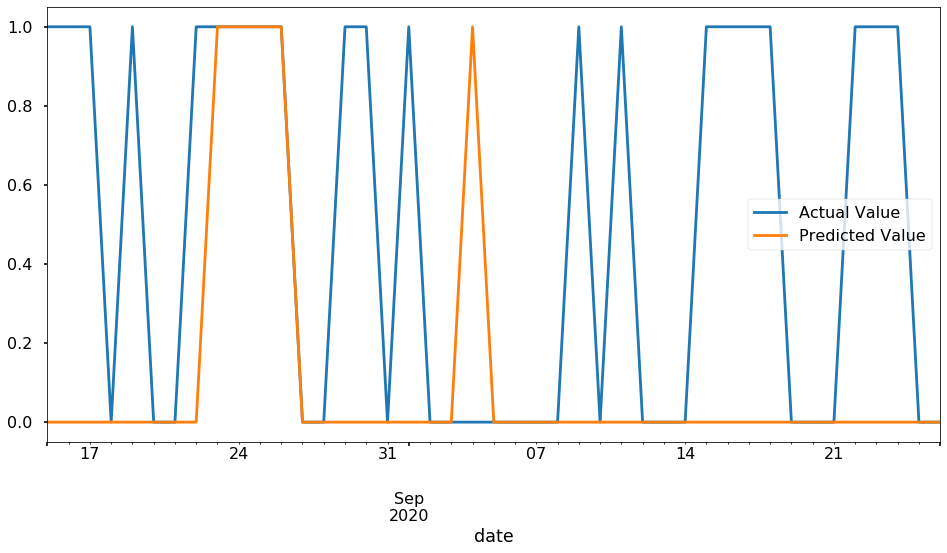

In [94]:
# Plot predicted results vs. actual results
Results[['Actual Value', 'Predicted Value']].plot(figsize=(16,8))

In [95]:
results = pd.concat([Results, trading_signals_df[['price','daily_return']]], 
                    axis=1,
                   join='inner')
results

Actual Value  Predicted Value      price  daily_return
date                                                              
2020-08-15           1.0              0.0  42.140000      0.003095
2020-08-16           1.0              0.0  42.270000      0.003085
2020-08-17           1.0              0.0  42.890000      0.014668
2020-08-18           0.0              0.0  42.890000      0.000000
2020-08-19           1.0              0.0  42.930000      0.000933
2020-08-20           0.0              0.0  42.580000     -0.008153
2020-08-21           0.0              0.0  42.340000     -0.005636
2020-08-22           1.0              0.0  42.400000      0.001417
2020-08-23           1.0              1.0  42.460000      0.001415
2020-08-24           1.0              1.0  42.620000      0.003768
2020-08-25           1.0              1.0  43.350000      0.017128
2020-08-26           1.0              1.0  43.390000      0.000923
2020-08-27           0.0              0.0  43.040000     -0.008066
2020-08-28           0.0              0.0  42.970000     -0.001626
2020-08-29           1.0              0.0  43.000000      0.000698
2020-08-30           1.0              0.0  43.030000      0.000698
2020-08-31           0.0              0.0  42.610000     -0.009761
2020-09-01           1.0              0.0  42.760000      0.003520
2020-09-02           0.0              0.0  41.510000     -0.029233
2020-09-03           0.0              0.0  41.370000     -0.003373
2020-09-04           0.0              1.0  39.770000     -0.038675
2020-09-05           0.0              0.0  39.017500     -0.018921
2020-09-06           0.0              0.0  38.265000     -0.019286
2020-09-07           0.0              0.0  37.512500     -0.019665
2020-09-08           0.0              0.0  36.760000     -0.020060
2020-09-09           1.0              0.0  38.050000      0.035092
2020-09-10           0.0              0.0  37.300000     -0.019711
2020-09-11           1.0              0.0  37.330000      0.000804
2020-09-12           0.0              0.0  37.306667     -0.000625
2020-09-13           0.0              0.0  37.283333     -0.000625
2020-09-14           0.0              0.0  37.260000     -0.000626
2020-09-15           1.0              0.0  38.280000      0.027375
2020-09-16           1.0              0.0  40.160000      0.049112
2020-09-17           1.0              0.0  40.970000      0.020169
2020-09-18           1.0              0.0  41.110000      0.003417
2020-09-19           0.0              0.0  40.510000     -0.014595
2020-09-20           0.0              0.0  39.910000     -0.014811
2020-09-21           0.0              0.0  39.310000     -0.015034
2020-09-22           1.0              0.0  39.600000      0.007377
2020-09-23           1.0              0.0  39.930000      0.008333
2020-09-24           1.0              0.0  40.310000      0.009517
2020-09-25           0.0              0.0  40.310000      0.000000
2020-09-26           0.0              0.0  40.310000      0.000000

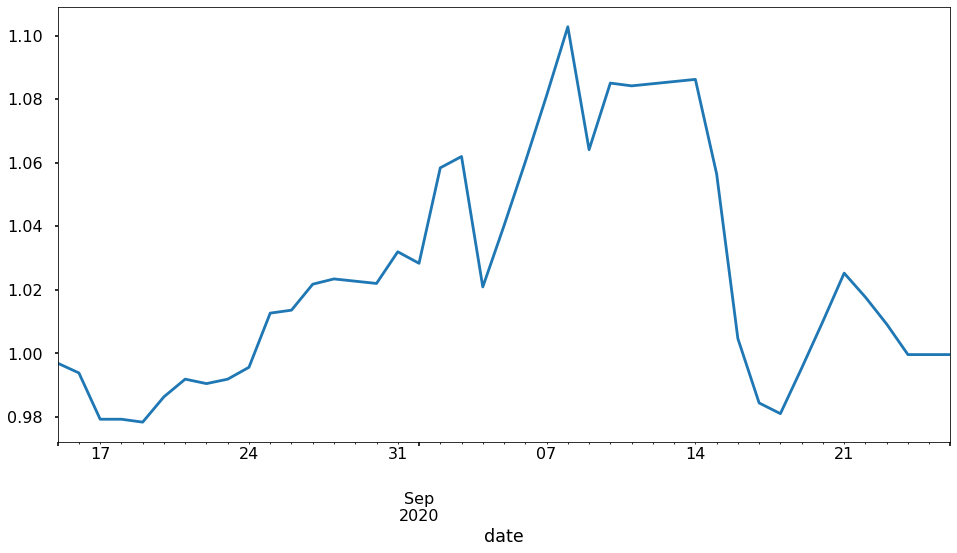

In [96]:
# Replace predicted values 0 to -1 to account for shorting
results['Predicted Value'].replace(0, -1, inplace=True)

# Calculate cumulative return of model and plot the result
(1 + (results['daily_return'] * results['Predicted Value'])).cumprod().plot(figsize=(16,8))

## Model Evaluation

In [97]:
from sklearn.metrics import (confusion_matrix, 
                             accuracy_score, 
                             classification_report)

In [98]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)


In [99]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


Predicted 0  Predicted 1
Actual 0           21            1
Actual 1           17            4

Accuracy Score : 0.5813953488372093
Classification Report
              precision    recall  f1-score   support

         0.0       0.55      0.95      0.70        22
         1.0       0.80      0.19      0.31        21

    accuracy                           0.58        43
   macro avg       0.68      0.57      0.50        43
weighted avg       0.67      0.58      0.51        43



## Feature Importance

In [100]:
# Random Forests in sklearn will automatically calculate feature importance
importances = model_rf.feature_importances_

In [101]:
# We can sort the features by their importance
sorted(zip(model_rf.feature_importances_, X_train.columns), reverse=True)

[(0.2761724793902304, 'price_u'),
 (0.22687312466311593, 'gdp_u'),
 (0.18783951747823108, 'prod_u'),
 (0.18121953445019864, 'uup_u'),
 (0.12789534401822408, 'vader_u')]

In [102]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model_rf.feature_importances_, 
                                         X_train.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')

In [103]:
importances_sorted

Feature Importances
1                           
vader_u             0.127895
uup_u               0.181220
prod_u              0.187840
gdp_u               0.226873
price_u             0.276172

In [104]:
importances_sorted.index = ['UUP', 'Twitter Vader', 'Production', 'Hist. Prices', 'US GDP']

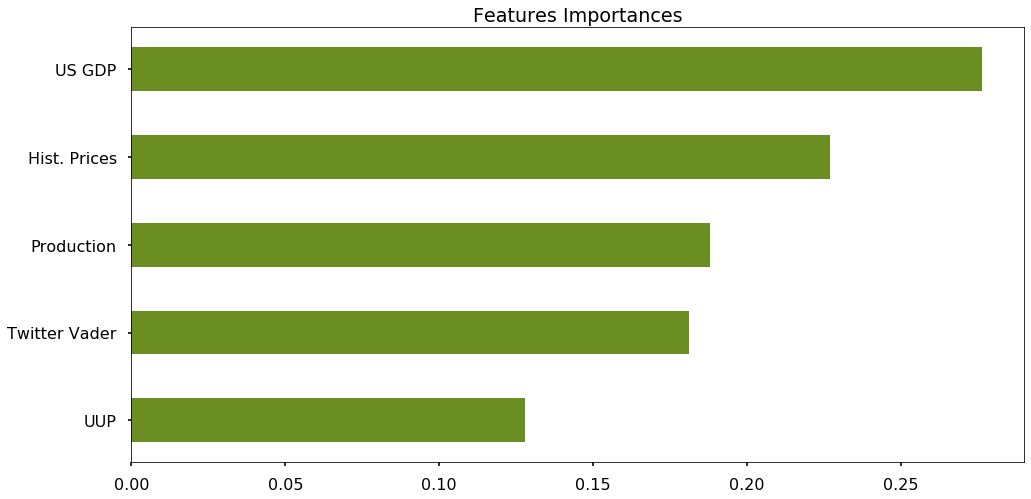

In [105]:
plt.figure(figsize=(16,8))
plt.barh(importances_sorted.index,
        importances_sorted['Feature Importances'],
        color = 'olivedrab',
        height=0.5)
plt.title('Features Importances')
plt.savefig('features.png')
plt.show()

In [106]:
from sklearn.metrics import precision_recall_curve

In [107]:
probs = model_rf.predict_proba(X_test)[:, 1]

In [108]:
precision, recall, _ = precision_recall_curve(y_test, probs, pos_label=1)

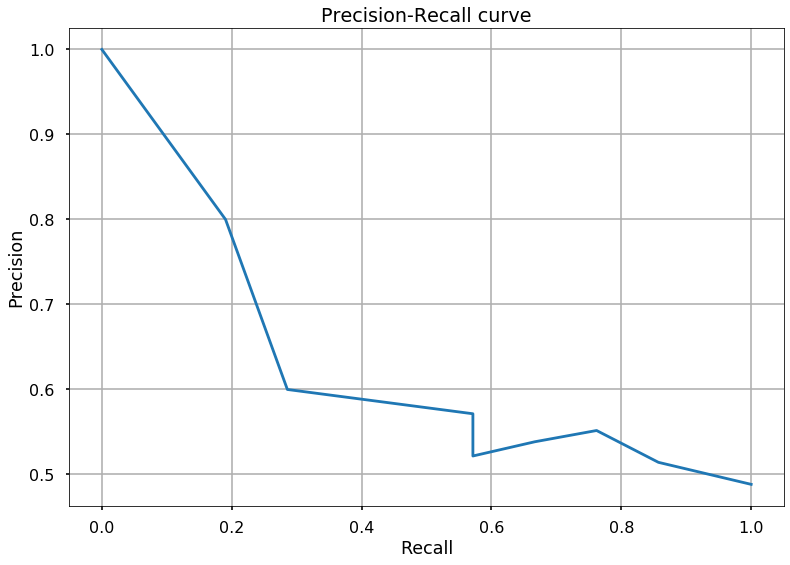

In [109]:
plt.plot(recall, precision, marker='x')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.grid()
plt.savefig('Precision-Recall.png')

In [110]:
# Import the roc_curve and auc metrics from sklearn
from sklearn.metrics import roc_curve, auc

In [111]:
# Making predictions to feed the roc_curve module
train_predictions = model_rf.predict(X_train)
test_predictions = model_rf.predict(X_test)

In [112]:
# Calculate the ROC curve and AUC for the training set
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, train_predictions)
auc_train = auc(fpr_train, tpr_train)
auc_train = round(auc_train, 4)

# Calculate the ROC curve and AUC for the testing set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_predictions)
auc_test = auc(fpr_test, tpr_test)
auc_test = round(auc_test, 4)

In [113]:
# Create a DataFrame with the fpr and tpr results
roc_df_train = pd.DataFrame({"FPR Train": fpr_train, "TPR Train": tpr_train,})

roc_df_test = pd.DataFrame({"FPR Test": fpr_test, "TPR Test": tpr_test,})

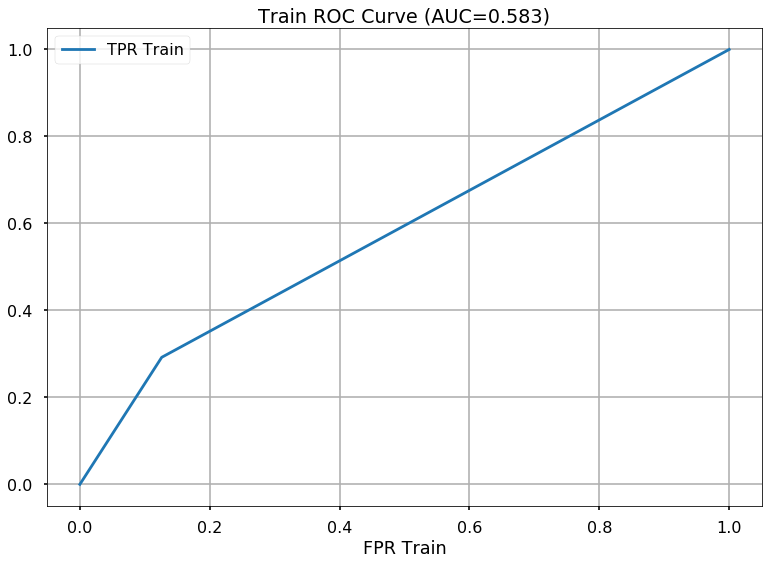

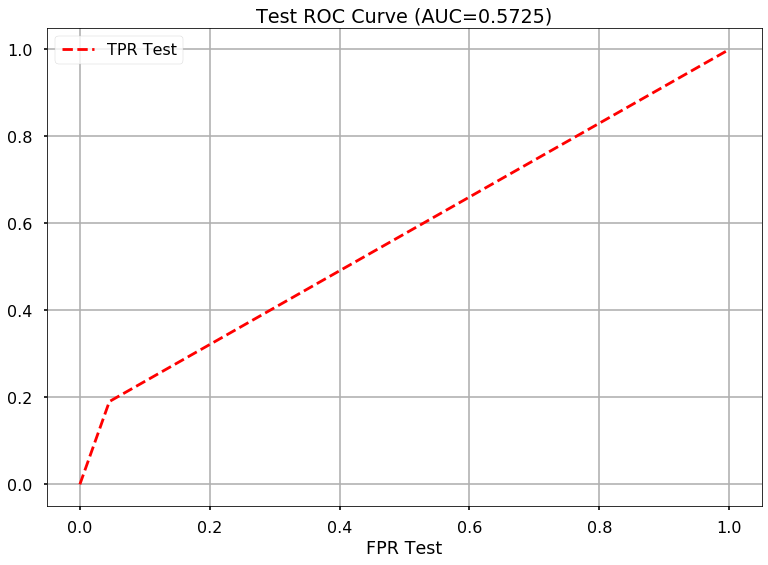

In [125]:
# Plotting the ROC Curves
roc_df_train.plot(
    x="FPR Train",
    y="TPR Train",
    xlim=([-0.05, 1.05]),
    title=f"Train ROC Curve (AUC={auc_train})",
)
plt.grid()
plt.savefig('train_roc.png')
roc_df_test.plot(
    x="FPR Test",
    y="TPR Test",
    color="red",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve (AUC={auc_test})",
)
plt.grid()
plt.savefig('test_roc.png')

In [115]:
results

Actual Value  Predicted Value      price  daily_return
date                                                              
2020-08-15           1.0             -1.0  42.140000      0.003095
2020-08-16           1.0             -1.0  42.270000      0.003085
2020-08-17           1.0             -1.0  42.890000      0.014668
2020-08-18           0.0             -1.0  42.890000      0.000000
2020-08-19           1.0             -1.0  42.930000      0.000933
2020-08-20           0.0             -1.0  42.580000     -0.008153
2020-08-21           0.0             -1.0  42.340000     -0.005636
2020-08-22           1.0             -1.0  42.400000      0.001417
2020-08-23           1.0              1.0  42.460000      0.001415
2020-08-24           1.0              1.0  42.620000      0.003768
2020-08-25           1.0              1.0  43.350000      0.017128
2020-08-26           1.0              1.0  43.390000      0.000923
2020-08-27           0.0             -1.0  43.040000     -0.008066
2020-08-28           0.0             -1.0  42.970000     -0.001626
2020-08-29           1.0             -1.0  43.000000      0.000698
2020-08-30           1.0             -1.0  43.030000      0.000698
2020-08-31           0.0             -1.0  42.610000     -0.009761
2020-09-01           1.0             -1.0  42.760000      0.003520
2020-09-02           0.0             -1.0  41.510000     -0.029233
2020-09-03           0.0             -1.0  41.370000     -0.003373
2020-09-04           0.0              1.0  39.770000     -0.038675
2020-09-05           0.0             -1.0  39.017500     -0.018921
2020-09-06           0.0             -1.0  38.265000     -0.019286
2020-09-07           0.0             -1.0  37.512500     -0.019665
2020-09-08           0.0             -1.0  36.760000     -0.020060
2020-09-09           1.0             -1.0  38.050000      0.035092
2020-09-10           0.0             -1.0  37.300000     -0.019711
2020-09-11           1.0             -1.0  37.330000      0.000804
2020-09-12           0.0             -1.0  37.306667     -0.000625
2020-09-13           0.0             -1.0  37.283333     -0.000625
2020-09-14           0.0             -1.0  37.260000     -0.000626
2020-09-15           1.0             -1.0  38.280000      0.027375
2020-09-16           1.0             -1.0  40.160000      0.049112
2020-09-17           1.0             -1.0  40.970000      0.020169
2020-09-18           1.0             -1.0  41.110000      0.003417
2020-09-19           0.0             -1.0  40.510000     -0.014595
2020-09-20           0.0             -1.0  39.910000     -0.014811
2020-09-21           0.0             -1.0  39.310000     -0.015034
2020-09-22           1.0             -1.0  39.600000      0.007377
2020-09-23           1.0             -1.0  39.930000      0.008333
2020-09-24           1.0             -1.0  40.310000      0.009517
2020-09-25           0.0             -1.0  40.310000      0.000000
2020-09-26           0.0             -1.0  40.310000      0.000000

In [116]:
oil_df

Real  Predicted  price  Real u/d  Predicted u/d
date                                                        
2020-01-19  58.44  58.852348  58.44       0.0            0.0
2020-01-20  58.39  58.744961  58.39      -1.0           -1.0
2020-01-21  58.34  58.649117  58.34      -1.0           -1.0
2020-01-22  56.74  58.564667  56.74      -1.0           -1.0
2020-01-23  55.59  58.482338  55.59      -1.0           -1.0
...           ...        ...    ...       ...            ...
2020-09-22  39.60  48.603199  39.60       1.0            1.0
2020-09-23  39.93  48.657848  39.93       1.0            1.0
2020-09-24  40.31  48.713974  40.31       1.0            1.0
2020-09-25  40.31  48.771656  40.31       0.0            1.0
2020-09-26  40.31  48.830215  40.31       0.0            1.0

[252 rows x 5 columns]

In [121]:
out_df = pd.concat([oil_df, results], join='outer', axis=1)

In [122]:
out_df

Real  Predicted  price  Real u/d  Predicted u/d  Actual Value  \
date                                                                         
2020-01-19  58.44  58.852348  58.44       0.0            0.0           NaN   
2020-01-20  58.39  58.744961  58.39      -1.0           -1.0           NaN   
2020-01-21  58.34  58.649117  58.34      -1.0           -1.0           NaN   
2020-01-22  56.74  58.564667  56.74      -1.0           -1.0           NaN   
2020-01-23  55.59  58.482338  55.59      -1.0           -1.0           NaN   
...           ...        ...    ...       ...            ...           ...   
2020-09-22  39.60  48.603199  39.60       1.0            1.0           1.0   
2020-09-23  39.93  48.657848  39.93       1.0            1.0           1.0   
2020-09-24  40.31  48.713974  40.31       1.0            1.0           1.0   
2020-09-25  40.31  48.771656  40.31       0.0            1.0           0.0   
2020-09-26  40.31  48.830215  40.31       0.0            1.0           0.0   

            Predicted Value  price  daily_return  
date                                              
2020-01-19              NaN    NaN           NaN  
2020-01-20              NaN    NaN           NaN  
2020-01-21              NaN    NaN           NaN  
2020-01-22              NaN    NaN           NaN  
2020-01-23              NaN    NaN           NaN  
...                     ...    ...           ...  
2020-09-22             -1.0  39.60      0.007377  
2020-09-23             -1.0  39.93      0.008333  
2020-09-24             -1.0  40.31      0.009517  
2020-09-25             -1.0  40.31      0.000000  
2020-09-26             -1.0  40.31      0.000000  

[252 rows x 9 columns]

In [123]:
col_list = ['Real', 'Predicted', 'Real u/d', 'Predicted Value']
out_df = out_df[col_list]
out_df.columns = ['Real Price', 'Predicted Price', 'Real U/D', 'Predicted R/D']

<Figure size 1152x576 with 0 Axes>

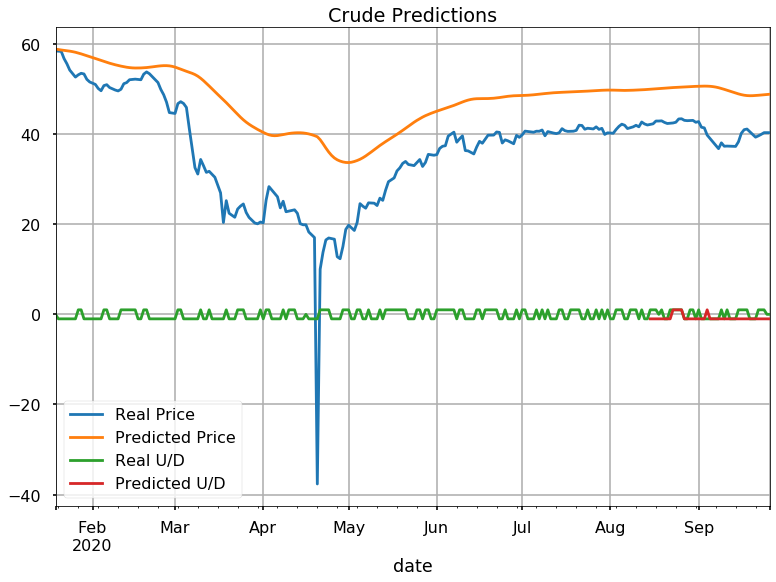

In [169]:
plt.figure(figsize=(16,8))
#col_list = ['Real', 'Predicated', 'up_down', 'Predicted Value']
out_df.plot(kind='line')

#plt.show()
#plt.plot(oil_df)
#plt.xticks(oil_df.index[::10],rotation=45)
#plt.legend()
#plt.plot(results['Predicted Value'])
plt.title('Crude Predictions')

plt.grid(True)
plt.legend(loc='best')
plt.savefig("rnn_rf_output.png")
plt.show()


In [126]:
out_df

Real Price  Predicted Price  Real U/D  Predicted R/D
date                                                            
2020-01-19       58.44        58.852348       0.0            NaN
2020-01-20       58.39        58.744961      -1.0            NaN
2020-01-21       58.34        58.649117      -1.0            NaN
2020-01-22       56.74        58.564667      -1.0            NaN
2020-01-23       55.59        58.482338      -1.0            NaN
...                ...              ...       ...            ...
2020-09-22       39.60        48.603199       1.0           -1.0
2020-09-23       39.93        48.657848       1.0           -1.0
2020-09-24       40.31        48.713974       1.0           -1.0
2020-09-25       40.31        48.771656       0.0           -1.0
2020-09-26       40.31        48.830215       0.0           -1.0

[252 rows x 4 columns]

In [134]:
out_df.rename(columns={'Predicted R/D': 'Predicted U/D'})

/Users/liwei2/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [135]:
out_df

Real Price  Predicted Price  Real U/D  Predicted U/D
date                                                            
2020-01-19       58.44        58.852348       0.0            NaN
2020-01-20       58.39        58.744961      -1.0            NaN
2020-01-21       58.34        58.649117      -1.0            NaN
2020-01-22       56.74        58.564667      -1.0            NaN
2020-01-23       55.59        58.482338      -1.0            NaN
...                ...              ...       ...            ...
2020-09-22       39.60        48.603199       1.0           -1.0
2020-09-23       39.93        48.657848       1.0           -1.0
2020-09-24       40.31        48.713974       1.0           -1.0
2020-09-25       40.31        48.771656       0.0           -1.0
2020-09-26       40.31        48.830215       0.0           -1.0

[252 rows x 4 columns]

In [142]:
x = out_df.index
real_price = out_df['Real Price']
pred_price = out_df['Predicted Price']

real_ud = out_df['Real U/D']
pred_ud = out_df['Predicted U/D']

# Part III: Visualization

### RNN & RF output plots

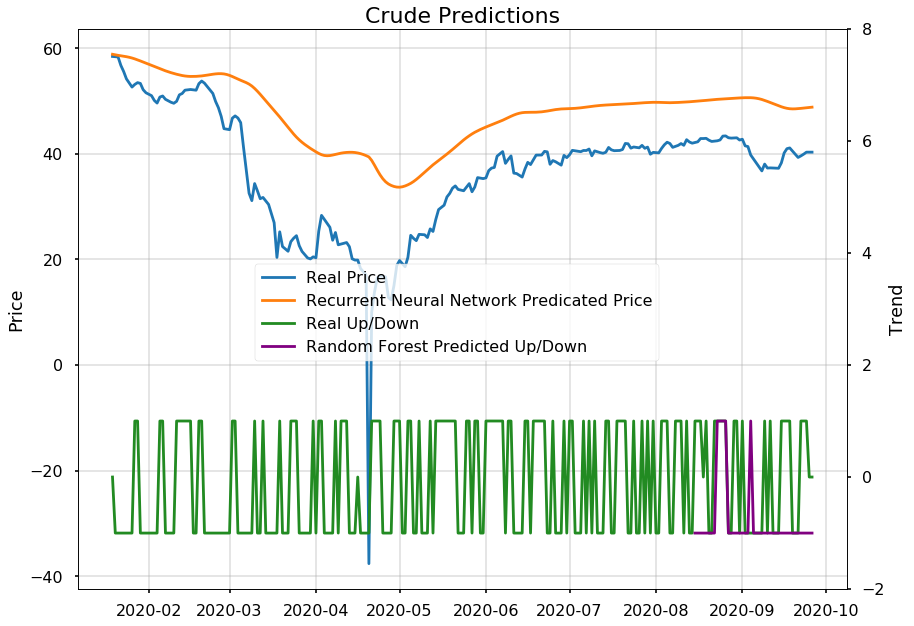

In [220]:

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1)
ax1.plot(x, real_price, label='Real Price')
ax1.plot(x, pred_price, label='Recurrent Neural Network Predicated Price')
# Plot Line2 (Right Y Axis) 
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, real_ud, label='Real Up/Down', color='forestgreen')
ax2.plot(x, pred_ud, label='Random Forest Predicted Up/Down', color = 'purple')
# Decorations
# ax1 (left Y axis)
#ax1.set_xlabel('Year', fontsize=20)
#ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Price')
#ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Trend")
ax2.set_ylim(-2,8)
#ax2.set_xlim('2020-08','2020-10')
#ax2.tick_params(axis='y', labelcolor='tab:blue')
#ax2.set_xticks(np.arange(0, len(x), 60))

ax2.set_title("Crude Predictions", fontsize=22)
#ax1.set_xlim(x[-60],x[-1])
#ax2.set_xlim(x[-60],x[-1])
#ax2.set_xticklabels(rotation=90, fontdict={'fontsize':10})
fig.tight_layout()
fig.legend(loc='center')
plt.savefig("rnn_rf_fig.png")
plt.show()

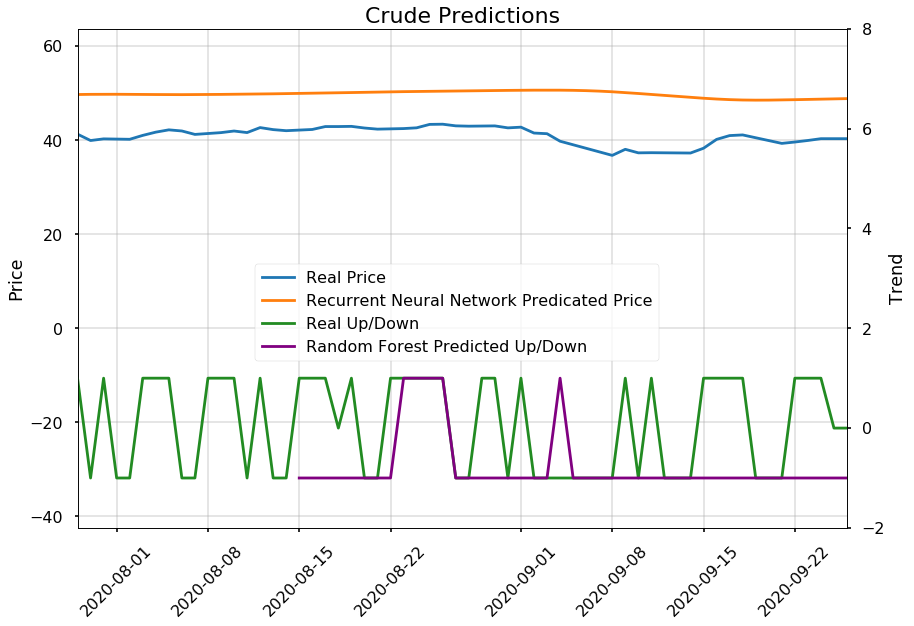

In [216]:

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1)
ax1.plot(x, real_price, label='Real Price')
ax1.plot(x, pred_price, label='Recurrent Neural Network Predicated Price')
# Plot Line2 (Right Y Axis) 
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, real_ud, label='Real Up/Down', color='forestgreen')
ax2.plot(x, pred_ud, label='Random Forest Predicted Up/Down', color = 'purple')
# Decorations
# ax1 (left Y axis)
#ax1.set_xlabel('Year', fontsize=20)
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Price')
#ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Trend")
ax2.set_ylim(-2,8)
#ax2.set_xlim('2020-08','2020-10')
#ax2.tick_params(axis='y', labelcolor='tab:blue')
#ax2.set_xticks(np.arange(0, len(x), 60))

ax2.set_title("Crude Predictions", fontsize=22)
ax1.set_xlim(x[-60],x[-1])
ax2.set_xlim(x[-60],x[-1])
#ax2.set_xticklabels(rotation=90, fontdict={'fontsize':10})
fig.tight_layout()
fig.legend(loc='center')
plt.savefig("rnn_rf_fig_zoom.png")
plt.show()

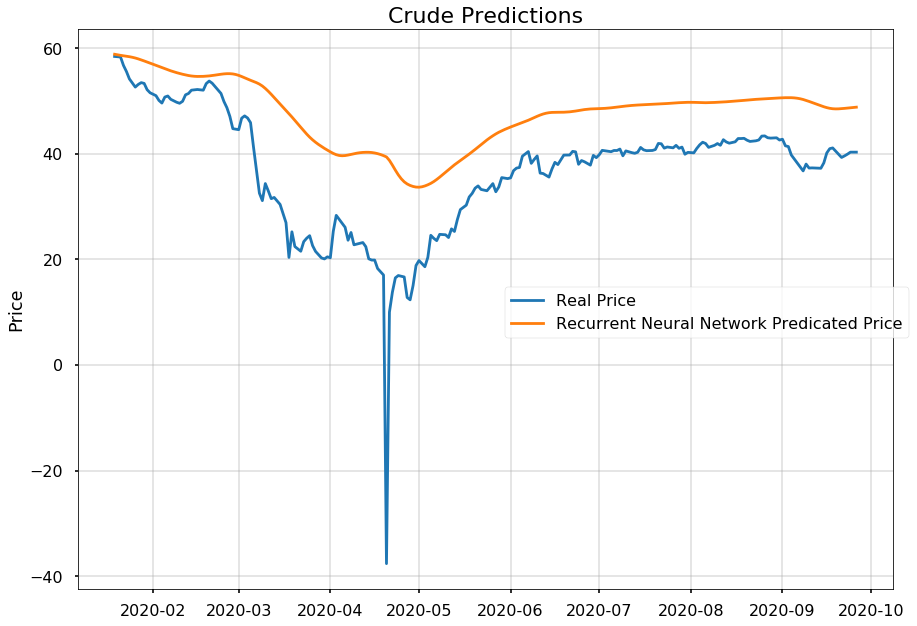

In [218]:

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1)
ax1.plot(x, real_price, label='Real Price')
ax1.plot(x, pred_price, label='Recurrent Neural Network Predicated Price')
# Decorations
# ax1 (left Y axis)
#ax1.set_xlabel('Year', fontsize=20)
#ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('Price')
#ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)
ax1.set_title("Crude Predictions", fontsize=22)
fig.tight_layout()
fig.legend(loc='center right')
plt.savefig("rnn_fig.png")
plt.show()

### table

In [190]:
output_table = out_df.iloc[-40:,[0, 2, 3]].hvplot.table()
hvplot.save(output_table, 'output_table.png')
#output_table.png

In [191]:
output_table

:Table   [date,Real Price,Real U/D,Predicted U/D]